In [ ]:
import kagglehub
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
!pip install split-folders

import os, shutil
import splitfolders

base_path = "/kaggle/input/gtsrb-german-traffic-sign/train"


selected_classes = ["0","21","12","3","4","15","16","1","25","22"]

# ========== 2. ننقلهم لفولدر جديد data_full ==========
if not os.path.exists("data_full"):
    os.makedirs("data_full")

    for cls in selected_classes:
        src = os.path.join(base_path, cls)
        dst = os.path.join("data_full", cls)
        shutil.copytree(src, dst)

# ========== 3. نعمل Split (train/val/test) ==========
splitfolders.ratio("data_full", output="data", seed=42, ratio=(.7, .2, .1))

Copying files: 11190 files [00:01, 7882.93 files/s]


In [ ]:
# ========== 1. استيراد المكتبات ==========
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random, os
import json
# ========== 2. إعداد Data Generators ==========
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_ds = datagen.flow_from_directory(
    "data/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_ds = datagen.flow_from_directory(
    "data/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_ds = datagen.flow_from_directory(
    "data/test",
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_ds.class_indices)
print("Classes:", train_ds.class_indices)

# ========== 3. بناء MobileNetV2 ==========
base_mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(128,128,3))
base_mobilenet.trainable = False  # نجمد ال weights

model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Found 7831 images belonging to 10 classes.
Found 2238 images belonging to 10 classes.
Found 1121 images belonging to 10 classes.
Classes: {'0': 0, '1': 1, '12': 2, '15': 3, '16': 4, '21': 5, '22': 6, '25': 7, '3': 8, '4': 9}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3) # ممكن نقلل ال epochs ل 2 مثلا

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


245/245 ━━━━━━━━━━━━━━━━━━━━ 146s 574ms/step - accuracy: 0.6721 - loss: 0.9747 - val_accuracy: 0.9214 - val_loss: 0.2331
Epoch 2/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 137s 560ms/step - accuracy: 0.9107 - loss: 0.2520 - val_accuracy: 0.9522 - val_loss: 0.1483
Epoch 3/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 127s 500ms/step - accuracy: 0.9364 - loss: 0.1803 - val_accuracy: 0.9625 - val_loss: 0.1169


In [ ]:
# ========== 5. التقييم ==========
print("\n✅ Testing Accuracy:")
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc*100:.2f}%")


✅ Testing Accuracy:
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9376 - loss: 0.1484
Test Accuracy: 95.90%


In [ ]:
model.save("traffic_model.h5")
print("Model saved as traffic_model.h5")

Model saved as traffic_model.h5


In [ ]:
# import tensorflow as tf
# import json
# import os

# # ========== إعداد البيانات ==========
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "data/train",  # غيره حسب مكان بياناتك
#     image_size=(64, 64),
#     batch_size=32
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "data/val",  # غيره حسب مكان بياناتك
#     image_size=(64, 64),
#     batch_size=32
# )

# # ========== بناء الموديل ==========
# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255, input_shape=(64, 64, 3)),
#     tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax")
# ])

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# # ========== التدريب ==========
# history = model.fit(train_ds, validation_data=val_ds, epochs=3)

# # ========== حفظ الموديل ==========
# model.save("traffic_model.h5")

# # ========== حفظ class_indices ==========
# class_indices = {name: idx for idx, name in enumerate(train_ds.class_names)}
# with open("class_indices.json", "w") as f:
#     json.dump(class_indices, f)

# print("✅ Model and class_indices saved!")


Found 7831 files belonging to 10 classes.
Found 2238 files belonging to 10 classes.
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 53s 206ms/step - accuracy: 0.5951 - loss: 1.2072 - val_accuracy: 0.9674 - val_loss: 0.1312
Epoch 2/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.9732 - loss: 0.0959 - val_accuracy: 0.9897 - val_loss: 0.0478
Epoch 3/3
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.9912 - loss: 0.0378 - val_accuracy: 0.9884 - val_loss: 0.0436


✅ Model and class_indices saved!


In [ ]:
# class_indices = {name: idx for idx, name in enumerate(train_ds.class_names)}
# with open("class_indices.json", "w") as f:
#     json.dump(class_indices, f)

# print("✅ Model and class_indices saved!")

✅ Model and class_indices saved!


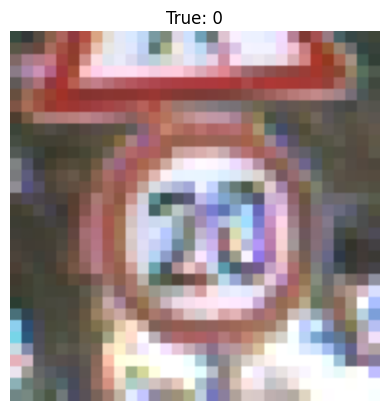

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: 1 (66.32%)



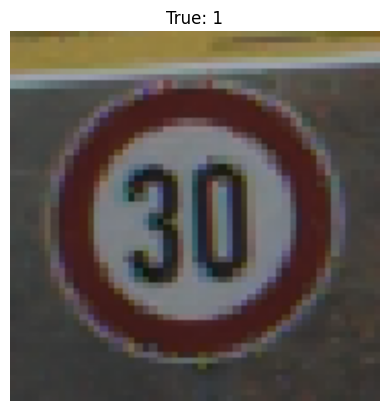

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: 1 (95.21%)



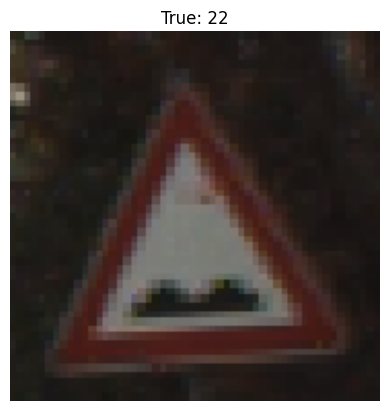

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: 22 (99.99%)



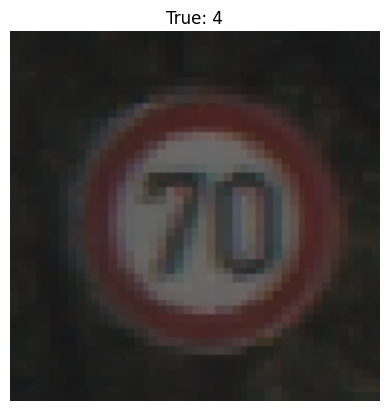

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: 4 (99.91%)



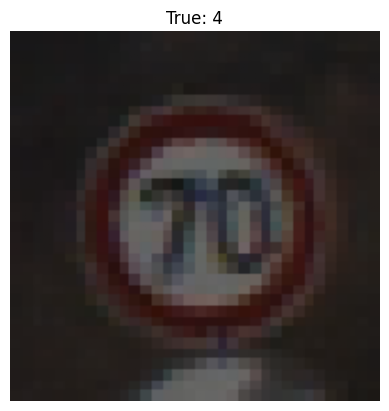

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: 4 (84.27%)



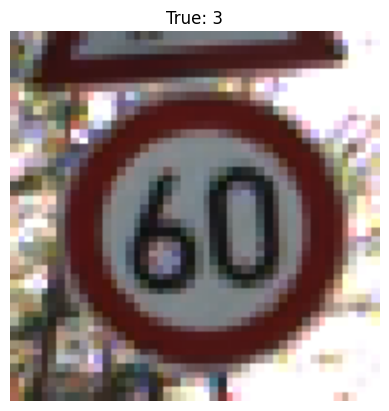

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction: 3 (93.37%)



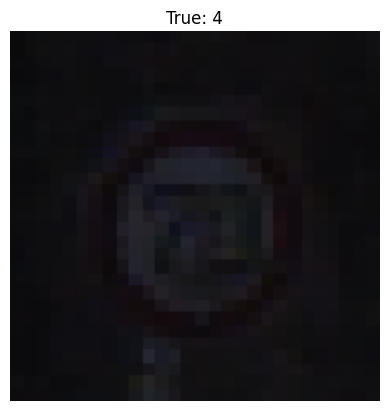

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: 4 (96.57%)



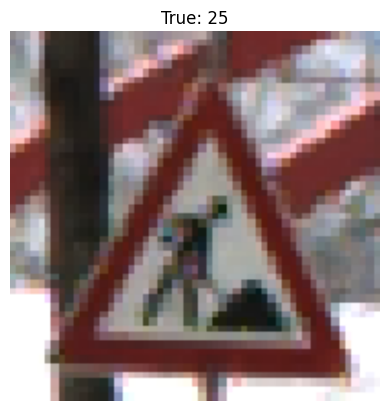

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: 25 (99.13%)



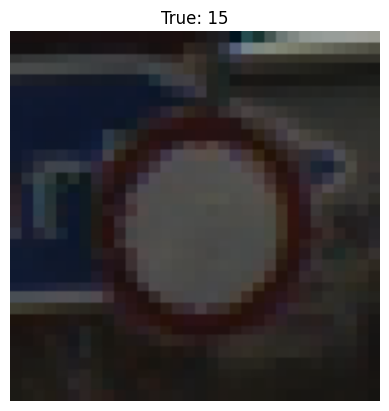

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: 15 (99.96%)



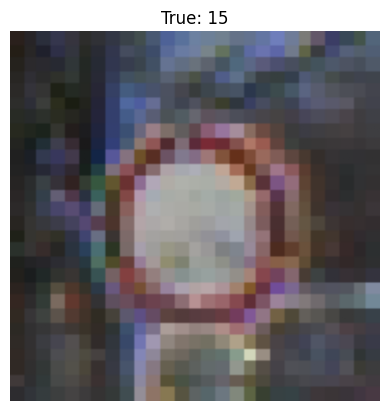

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction: 15 (99.48%)



In [ ]:
# ========== 6. تجربة صور عشوائية من test ==========
classes = list(train_ds.class_indices.keys())

for i in range(10):
    idx = random.randint(0, len(test_ds.filenames)-1)
    img_path = os.path.join("data/test", test_ds.filenames[idx])

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    plt.imshow(img_arr)
    plt.axis("off")
    plt.title(f"True: {test_ds.filenames[idx].split('/')[0]}")
    plt.show()

    pred = model.predict(img_arr[None,...])
    print(f"Prediction: {classes[np.argmax(pred)]} ({np.max(pred)*100:.2f}%)\n")